<a href="https://colab.research.google.com/github/vipin-jangra/face-age-estimation-CNN/blob/main/D1_CNN5_A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import keras
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [3]:
def preprocess_image(image_path):
    # Read grayscale image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize image to (224, 224)
    image = cv2.resize(image, (224, 224))
    # Convert grayscale to RGB by stacking the single channel
    image_rgb = np.stack((image,) * 3, axis=-1)
    return image_rgb

In [4]:
from google.colab import drive

drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/Dataset/Dataset2/crop_part1.zip'

Streaming output truncated to the last 5000 lines.
  inflating: crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170104204327523.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170105164106036.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170105172720493.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170108224608753.jpg.chip.jpg  
  inflating: crop_part1/34_1_2_20170109140259136.jpg.

In [5]:
# Define age ranges
age_ranges = [(1,3), (4,7) , (8,14), (15,24), (25,37), (38,47), (48,59), (60,116)]

# Function to map age to range index
def age_to_range(age, age_ranges):
    for idx, (start, end) in enumerate(age_ranges):
        if start <= age <= end:
            return idx
    return None

In [6]:
def preprocess_labels(labels, num_classes):
    # One-hot encode labels
    labels = to_categorical(labels, num_classes=num_classes)
    return labels

In [7]:
# Load and preprocess the dataset
image_dir = '/content/crop_part1'
images=[]
image_paths = []
age_labels = []
age_groups = []
target_size = (224, 224)

for filename in os.listdir(image_dir):
  if filename.endswith(".jpg"):
    age = int(filename.split('_')[0])
    range_index = age_to_range(age, age_ranges)
    age_labels.append(range_index)

    image_path = os.path.join(image_dir, filename)
    image = preprocess_image(image_path)
    images.append(image)
    image_paths.append(image_path)

images = np.array(images)
age_groups = age_labels
age_labels = preprocess_labels(age_labels, len(age_ranges))

In [8]:
# Print shapes
print(f"Images shape: {images.shape}")
print(f"Labels shape: {age_labels.shape}")

Images shape: (9780, 224, 224, 3)
Labels shape: (9780, 8)


In [9]:
def age_group_to_interval(group_index):
    if group_index < 0 or group_index >= len(age_ranges):
        return "Unknown"

    start, end = age_ranges[group_index]
    return f"{start}-{end}"

In [10]:
import pandas as pd
df = pd.DataFrame()
age_intervals = [age_group_to_interval(age) for age in age_groups]
df['images_path'],df['age'] = image_paths,age_intervals
df.head(10)

,images_path,age
0,/content/crop_part1/32_0_4_20170103235323876.j...,25-37
1,/content/crop_part1/3_1_2_20161219151433163.jp...,1-3
2,/content/crop_part1/30_1_0_20170103183908075.j...,25-37
3,/content/crop_part1/47_1_0_20170104184702870.j...,38-47
4,/content/crop_part1/53_0_0_20170104212411036.j...,48-59
5,/content/crop_part1/20_0_0_20170104230042553.j...,15-24
6,/content/crop_part1/47_0_0_20170104211830788.j...,38-47
7,/content/crop_part1/37_1_0_20170109134546708.j...,25-37
8,/content/crop_part1/9_0_2_20170110215518068.jp...,8-14
9,/content/crop_part1/2_1_4_20170103210839634.jp...,1-3


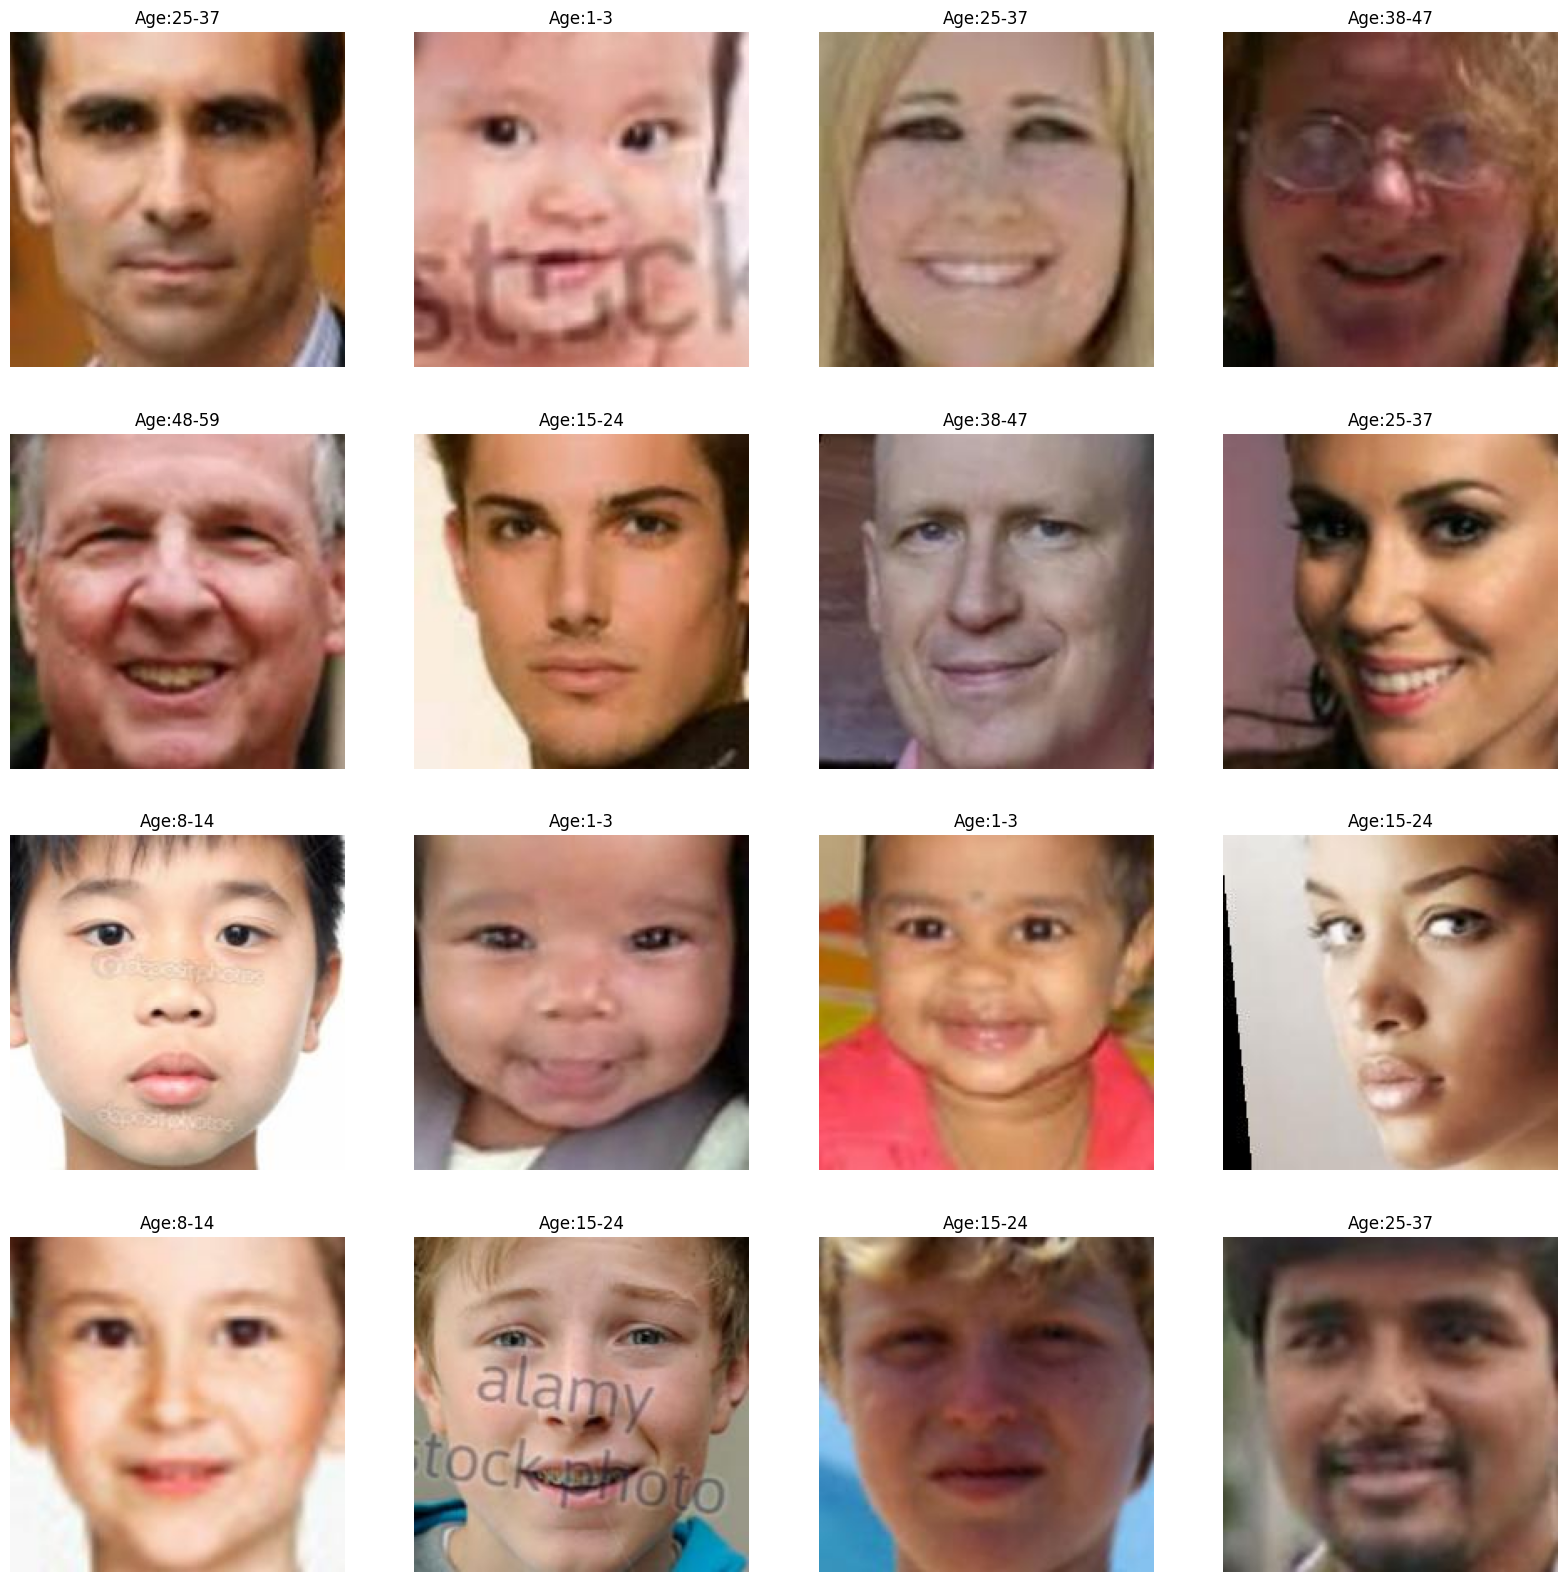

In [11]:
plt.figure(figsize=(20,20))
samples = df.iloc[0:16]

for index,sample,age in samples.itertuples():
  plt.subplot(4,4,index+1)
  img = load_img(sample)
  img = np.array(img)
  plt.axis('off')
  plt.title(f'Age:{age}')
  plt.imshow(img)

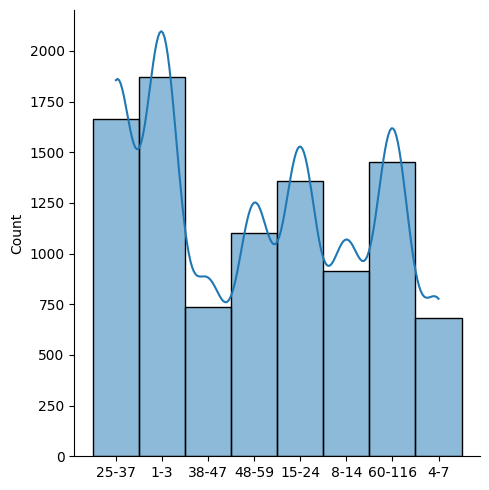

In [12]:
#age distribution
sns.displot(data=age_intervals,kde=True)

In [13]:
train_images, test_images, train_age_groups, test_age_groups = train_test_split(images, age_labels, test_size=0.2, random_state=42)


In [19]:
bnmomemtum=0.9
def fire(x, squeeze, expand):
  y  = keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y = keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
  y1 = keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
  return keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

x = keras.layers.Input(shape=[224, 224, 3]) # input is 192x192 pixels RGB

y = keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
y = fire_module(24, 48)(y)
y = keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128)(y)
y = keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = keras.layers.GlobalAveragePooling2D()(y)
y = keras.layers.Dense(len(age_ranges), activation='softmax')(y)

model = keras.Model(x, y)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Dataset/Dataset2/model-weights/CROP_D1_CNN3_A4.h5',  # Filepath to save the best model
    monitor='val_accuracy',  # Metric to monitor
    verbose=1,
    save_best_only=True,  # Only save the best model
    mode='max'  # Mode to determine best (maximizing validation accuracy)
)


In [21]:
model.fit(train_images, train_age_groups, validation_split=0.2, epochs=60, batch_size=32, callbacks=[model_checkpoint], shuffle=False)


Epoch 1/60
196/196 [==============================] - ETA: 0s - loss: 1.8024 - accuracy: 0.3421
Epoch 1: val_accuracy improved from -inf to 0.36805, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/CROP_D1_CNN3_A4.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


196/196 [==============================] - 49s 162ms/step - loss: 1.8024 - accuracy: 0.3421 - val_loss: 1.7153 - val_accuracy: 0.3681
Epoch 2/60
196/196 [==============================] - ETA: 0s - loss: 1.6122 - accuracy: 0.4104
Epoch 2: val_accuracy improved from 0.36805 to 0.41470, saving model to /content/drive/MyDrive/Dataset/Dataset2/model-weights/CROP_D1_CNN3_A4.h5
196/196 [==============================] - 28s 141ms/step - loss: 1.6122 - accuracy: 0.4104 - val_loss: 1.5955 - val_accuracy: 0.4147
Epoch 3/60
196/196 [==============================] - ETA: 0s - loss: 1.5290 - accuracy: 0.4406
Epoch 3: val_accuracy did not improve from 0.41470
196/196 [==============================] - 27s 137ms/step - loss: 1.5290 - accuracy: 0.4406 - val_loss: 1.5688 - val_accuracy: 0.4032
Epoch 4/60
196/196 [==============================] - ETA: 0s - loss: 1.4685 - accuracy: 0.4625
Epoch 4: val_accuracy improved from 0.41470 to 0.42939, saving model to /content/drive/MyDrive/Dataset/Dataset2/mo

In [22]:
# Load the best model
model.load_weights('/content/drive/MyDrive/Dataset/Dataset2/model-weights/CROP_D1_CNN3_A4.h5')

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_age_groups)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


62/62 [==============================] - 3s 49ms/step - loss: 1.4000 - accuracy: 0.5184
Test Accuracy: 51.84%


In [23]:

predictions = model.predict(test_images)

# Convert predictions to class labels if needed
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_age_groups, axis=1)

62/62 [==============================] - 3s 44ms/step


In [24]:
# Example metrics calculation
from sklearn.metrics import classification_report

print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       376
           1       0.33      0.29      0.31       139
           2       0.45      0.32      0.38       171
           3       0.39      0.64      0.48       257
           4       0.48      0.47      0.48       356
           5       0.30      0.23      0.26       168
           6       0.37      0.20      0.26       199
           7       0.59      0.69      0.64       290

    accuracy                           0.52      1956
   macro avg       0.47      0.46      0.45      1956
weighted avg       0.51      0.52      0.51      1956



In [25]:
# Calculate classification metrics
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.52
Precision: 0.51
Recall: 0.52
F1-score: 0.51


In [26]:
# Calculate accuracy for each class
class_accuracies = {}
for idx, (start, end) in enumerate(age_ranges):
    # Filter predictions and true labels for the current class
    mask = (true_classes == idx)
    accuracy = accuracy_score(true_classes[mask], predicted_classes[mask])
    class_accuracies[f'{start}-{end}'] = accuracy

In [27]:
# Print accuracy for each class
for age_range, accuracy in class_accuracies.items():
    print(f'Accuracy for age range {age_range}: {accuracy:.2f}')

Accuracy for age range 1-3: 0.82
Accuracy for age range 4-7: 0.29
Accuracy for age range 8-14: 0.32
Accuracy for age range 15-24: 0.64
Accuracy for age range 25-37: 0.47
Accuracy for age range 38-47: 0.23
Accuracy for age range 48-59: 0.20
Accuracy for age range 60-116: 0.69


In [28]:
from sklearn.metrics import confusion_matrix
# Detailed classification report
print('\nClassification Report:')
print(classification_report(true_classes, predicted_classes, target_names=[f'{start}-{end}' for start, end in age_ranges]))

# Confusion Matrix
print('\nConfusion Matrix:')
print(confusion_matrix(true_classes, predicted_classes))


Classification Report:
              precision    recall  f1-score   support

         1-3       0.84      0.82      0.83       376
         4-7       0.33      0.29      0.31       139
        8-14       0.45      0.32      0.38       171
       15-24       0.39      0.64      0.48       257
       25-37       0.48      0.47      0.48       356
       38-47       0.30      0.23      0.26       168
       48-59       0.37      0.20      0.26       199
      60-116       0.59      0.69      0.64       290

    accuracy                           0.52      1956
   macro avg       0.47      0.46      0.45      1956
weighted avg       0.51      0.52      0.51      1956


Confusion Matrix:
[[309  47   3  12   2   1   0   2]
 [ 34  40  17  37   6   2   1   2]
 [ 10  25  55  60  13   2   2   4]
 [  3   5  20 165  49   6   2   7]
 [  6   1   8 105 167  39   9  21]
 [  2   2   3  18  56  39  18  30]
 [  2   1   3  16  38  28  40  71]
 [  2   1  12  11  14  15  36 199]]
